In [17]:
import argparse
from dotenv import load_dotenv
import earthaccess
import os
import earthaccess
from osgeo import gdal
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import hvplot.xarray
import holoviews as hv
import sys
sys.path.append('../modules/')
from emit_tools import emit_xarray

# This will ignore some warnings caused by holoviews
import warnings
warnings.simplefilter('ignore')

In [3]:
# Log in to Earthdata
load_dotenv()
earthaccess.login(strategy="environment", persist=True)

In [18]:
# data paths of L2A and L2B
l2a_path = "../../data/registration_test/EMIT_L2A_RFL_001_20241020T170504_2429411_003.nc"
l2b_path = "../../data/registration_test/EMIT_L2B_CH4ENH_001_20241020T170504_2429411_003.tif"

In [19]:
l2a_geo = emit_xarray(l2a_path, ortho=True)

In [34]:
l2a_geo

<xarray.Dataset> Size: 5GB
Dimensions:           (latitude: 1999, longitude: 2173, wavelengths: 285)
Coordinates:
  * wavelengths       (wavelengths) float32 1kB 381.0 388.4 ... 2.493e+03
    fwhm              (wavelengths) float32 1kB ...
    good_wavelengths  (wavelengths) float32 1kB ...
  * latitude          (latitude) float64 16kB 34.71 34.71 34.71 ... 33.63 33.63
  * longitude         (longitude) float64 17kB -85.11 -85.11 ... -83.93 -83.93
    elev              (latitude, longitude) float32 17MB -9.999e+03 ... -9.99...
    spatial_ref       int64 8B 0
Data variables:
    reflectance       (latitude, longitude, wavelengths) float32 5GB -9.999e+...
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-8.51101770e+01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20241020T170504_24294...
    Orthorectified:                    True

In [11]:
with rasterio.open(l2b_path) as src:
     # オルソ補正のための変換パラメータを計算する
    transform, width, height = calculate_default_transform(
        src.crs, src.crs, src.width, src.height, *src.bounds
    )

    # オルソ補正されたデータを格納するためのメタデータを更新
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": src.crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # オルソ補正してデータを保存
    l2b_ortho = np.empty((src.count, height, width), dtype=src.dtypes[0])
    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=l2b_ortho[i - 1],
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=src.crs,
            resampling=Resampling.nearest,  # 最近傍補間
        )
# l2b_orthoの欠損値処理
l2b_ortho[l2b_ortho == -9999] = np.nan
l2b_ortho = l2b_ortho.squeeze()

In [12]:
l2b_ortho.shape

(1999, 2173)

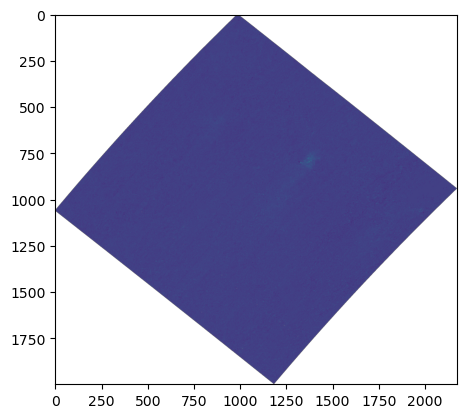

<Axes: >

In [14]:
# l2b_orthoを表示
show(l2b_ortho, cmap="viridis")

In [35]:
# 再投影されたL2AデータとL2Bデータを保存
np.save('../../data/registration_test/l2a.npy', l2a_geo.reflectance.data)
np.save('../../data/registration_test/l2b.npy', l2b_ortho)

In [37]:
# l2b.npyを読み込む
l2b_ortho = np.load('../../data/registration_test/l2b.npy')
l2b_ortho.shape

(406, 371)